## BMENE4460 Final Project
### Eugénie Dulout & Antoine Andurao

**Multi-view ViT with 1 slice from each direction**

This notebook contains our unfinished experiment with a MultiView ViT.

In this file, the input to each submodel ViT was a [3, 224, 224] Tensor, each channel being a the same slice from the same MRI (the same image is stacked 3 times because each model was pretrained on color images).

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import shutil
import nibabel as nib
import numpy as np
from glob import glob
from PIL import Image
from skimage import exposure
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

import time
from tempfile import TemporaryDirectory

In [3]:
# Set random seed for reproducibility
np.random.seed(4460)
torch.manual_seed(4460)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

class CLAHE():
    def __init__(self, clip_limit=0.02, tile_grid_size=(8, 8)):
        """
        Initialize CLAHE parameters.
        :param clip_limit: Threshold for contrast limiting.
        :param tile_grid_size: Size of the grid for the histogram equalization.
        """
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        """
        Apply CLAHE to a torch Tensor image.
        :param img: The input image torch Tensor.
        :return: Image after CLAHE as a torch Tensor.
        """
        # Ensure the image tensor is on CPU and convert it to numpy
        if isinstance(img, torch.Tensor):
            img = img.cpu()

        img_np = img.numpy()

        # Normalize the image data to [0, 1] for processing with skimage
        img_min = img_np.min()
        img_max = img_np.max()
        img_np = (img_np - img_min) / (img_max - img_min)

        # Apply CLAHE
        if img_np.ndim == 3:
            img_np = img_np[0]  # Remove channel dimension for processing

        clahe = exposure.equalize_adapthist(
            img_np,
            clip_limit=self.clip_limit,
            nbins=256,
            kernel_size=self.tile_grid_size
        )

        # Rescale back to the original range
        clahe = clahe * (img_max - img_min) + img_min

        # Convert back to a tensor
        clahe_tensor = torch.from_numpy(clahe).float()

        # Re-add the channel dimension if it was initially present
        if img.ndim == 3:
            clahe_tensor = clahe_tensor.unsqueeze(0)

        return clahe_tensor

class To3Channels:
    """Transform to duplicate 1-channel image to 3-channel image."""
    def __call__(self, x):
        return torch.cat([x, x, x], dim=0)

data_dir = "/content/drive/MyDrive/BMENE4460/Final Project/data_ADNI"

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          CLAHE(),
          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
          To3Channels(),
    ]),
    'validation': transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          CLAHE(),
          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
          To3Channels(),
    ]),
    'test': transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          CLAHE(),
          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
          To3Channels(),
    ]),
}

sagittal_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "sagittal", x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}
sagittal_dataloaders = {x: torch.utils.data.DataLoader(sagittal_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'validation', 'test']}
coronal_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "coronal", x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}
coronal_dataloaders = {x: torch.utils.data.DataLoader(coronal_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'validation', 'test']}
axial_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "coronal", x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}
axial_dataloaders = {x: torch.utils.data.DataLoader(axial_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(sagittal_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = sagittal_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([3, 224, 224])


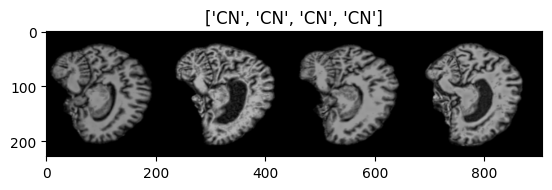

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(sagittal_dataloaders['train']))

print(inputs[0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
save_dir = "/content/drive/MyDrive/BMENE4460/Final Project/saved_models/"
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")  # Outputs the device being used

def compute_heatmap(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad = True
    with torch.set_grad_enabled(True):
        output = model(image.unsqueeze(0))
        predicted_class = torch.argmax(output, dim=1)
        model.vgg.classifier[6].weight.grad = None
        output[:, predicted_class].backward()

        heatmap = image.grad.squeeze().abs().detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
    return heatmap

def plot_heatmap(image, heatmap, title):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

def train(model, train_loader, val_loader, optimizer, criterion, device, save_dir, model_name="", epochs=10, patience=5):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Ensure the save directory exists

    train_losses = []
    val_losses = []
    accuracies = []

    best_val_acc = 0
    best_epoch = 0
    epochs_no_improve = 0

    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item() * images.size(0)

                predicted_labels = torch.argmax(output, dim=1)
                predictions.extend(predicted_labels.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        accuracy = accuracy_score(true_labels, predictions)
        accuracies.append(accuracy)

        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

        if accuracy > best_val_acc:
            best_val_acc = accuracy

            if os.path.exists(os.path.join(save_dir, f'{model_name}_epoch_{best_epoch}.pt')):
              os.remove(os.path.join(save_dir, f'{model_name}_epoch_{best_epoch}.pt'))
            # Save the model
            model_path = os.path.join(save_dir, f'{model_name}_epoch_{epoch}.pt')
            torch.save(model.state_dict(), model_path)

            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    # Plot loss and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return best_epoch

Running on: cuda


In [7]:
def load_by_epoch(model, model_name, save_dir, best_epoch, device):
  # Construct the model file name based on the best_epoch
    model_filename = f'{model_name}_epoch_{best_epoch}.pt'
    model_path = os.path.join(save_dir, model_filename)

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model found for best_epoch {best_epoch} at {model_path}")

    # Load the model
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    return model

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns  # Ensure seaborn is installed for better visualization

def cm_and_acc(model, test_loader, device):

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    labels = sorted(list(set(true_labels)))  # Get sorted list of classes

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["CN", "AD"], yticklabels=["CN", "AD"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Display accuracy
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy * 100:.2f}%', ha='center', fontsize=12)
    plt.show()

    return accuracy

In [9]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

def calculate_specificity(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            # Assuming outputs are logits; apply sigmoid if needed
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(np.int32)  # Threshold the probabilities to obtain binary predictions

            y_scores.extend(probs[:, 1])  # Store probabilities for AUC calculation
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred, y_scores

**ViT multi view**

In [10]:
!pip install timm

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import timm

# Define the MultiView ViT model
class MultiViewViT(nn.Module):
    def __init__(self, num_classes=2):
        super(MultiViewViT, self).__init__()
        # Define separate vision transformers for each view
        self.vit_c = ViT(num_classes)
        self.vit_a = ViT(num_classes)
        self.vit_s = ViT(num_classes)

        # Final classification layer
        self.fc = nn.Linear(num_classes * 3, num_classes)  # Combine representations from all views

    def forward(self, x_c, x_a, x_s):
        # Forward pass for each view
        out_c = self.vit_c(x_c)
        out_a = self.vit_a(x_a)
        out_s = self.vit_s(x_s)

        # Concatenate representations
        out = torch.cat((out_c, out_a, out_s), dim=1)  # Concatenate along the channel dimension

        # Final classification
        out = self.fc(out)

        return out

# Define the ViT model
class ViT(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x




In [12]:
# Function for training
def train(model, train_loader_c, train_loader_a, train_loader_s, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_batches = min(len(train_loader_c), len(train_loader_a), len(train_loader_s))
    for batch_idx in tqdm(range(total_batches)):
        batch_c = next(iter(train_loader_c))
        batch_a = next(iter(train_loader_a))
        batch_s = next(iter(train_loader_s))

        inputs_c, labels_c = batch_c
        inputs_a, labels_a = batch_a
        inputs_s, labels_s = batch_s

        inputs_c, inputs_a, inputs_s = inputs_c.to(device), inputs_a.to(device), inputs_s.to(device)
        labels_c, labels_a, labels_s = labels_c.to(device), labels_a.to(device), labels_s.to(device)

        optimizer.zero_grad()

        outputs_c = model.vit_c(inputs_c)
        outputs_a = model.vit_a(inputs_a)
        outputs_s = model.vit_s(inputs_s)

        loss_c = criterion(outputs_c, labels_c)
        loss_a = criterion(outputs_a, labels_a)
        loss_s = criterion(outputs_s, labels_s)

        loss = (loss_c + loss_a + loss_s) / 3.0
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / total_batches


# Function for validation
def validate(model, val_loader_c, val_loader_a, val_loader_s, criterion, device):
    model.eval()
    all_predictions = []
    all_targets = []
    running_loss = 0.0
    total_batches = min(len(val_loader_c), len(val_loader_a), len(val_loader_s))
    with torch.no_grad():
        for batch_idx in tqdm(range(total_batches)):
            batch_c = next(iter(val_loader_c))
            batch_a = next(iter(val_loader_a))
            batch_s = next(iter(val_loader_s))

            inputs_c, labels_c = batch_c
            inputs_a, labels_a = batch_a
            inputs_s, labels_s = batch_s

            inputs_c, inputs_a, inputs_s = inputs_c.to(device), inputs_a.to(device), inputs_s.to(device)
            labels_c, labels_a, labels_s = labels_c.to(device), labels_a.to(device), labels_s.to(device)

            outputs_c = model.vit_c(inputs_c)
            outputs_a = model.vit_a(inputs_a)
            outputs_s = model.vit_s(inputs_s)

            loss_c = criterion(outputs_c, labels_c)
            loss_a = criterion(outputs_a, labels_a)
            loss_s = criterion(outputs_s, labels_s)

            running_loss += (loss_c.item() + loss_a.item() + loss_s.item()) / 3.0

            predictions_c = torch.argmax(outputs_c, dim=1)
            predictions_a = torch.argmax(outputs_a, dim=1)
            predictions_s = torch.argmax(outputs_s, dim=1)
            all_predictions.extend(predictions_c.cpu().numpy())
            all_predictions.extend(predictions_a.cpu().numpy())
            all_predictions.extend(predictions_s.cpu().numpy())

            all_targets.extend(labels_c.cpu().numpy())
            all_targets.extend(labels_a.cpu().numpy())
            all_targets.extend(labels_s.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    auc = roc_auc_score(all_targets, all_predictions)

    return running_loss / total_batches, accuracy, f1, auc


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = MultiViewViT().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 25
for epoch in range(num_epochs):
    train_loss = train(model, coronal_dataloaders["train"], axial_dataloaders["train"], sagittal_dataloaders["train"], criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, val_auc = validate(model, coronal_dataloaders["validation"], axial_dataloaders["train"], sagittal_dataloaders["train"], criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val F1: {val_f1}, Val AUC: {val_auc}")

# Print final evaluation metrics
print("Final Evaluation:")
val_loss, val_accuracy, val_f1, val_auc = validate(model, coronal_dataloaders["validation"], axial_dataloaders["train"], sagittal_dataloaders["train"], criterion, device)
print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val F1: {val_f1}, Val AUC: {val_auc}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 64/64 [01:38<00:00,  1.54s/it]


Epoch 1/25, Train Loss: 0.5714239163695285, Val Loss: 0.9845157683372084, Val Accuracy: 0.77734375, Val F1: 0.8747252747252747, Val AUC: 0.5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Epoch 2/25, Train Loss: 0.34807657561669714, Val Loss: 1.1680427487735865, Val Accuracy: 0.7395833333333334, Val F1: 0.8502994011976047, Val AUC: 0.5


100%|██████████| 64/64 [00:51<00:00,  1.24it/s]


Epoch 3/25, Train Loss: 0.28779999166068887, Val Loss: 0.8250357227904411, Val Accuracy: 0.7916666666666666, Val F1: 0.8837209302325582, Val AUC: 0.5


100%|██████████| 64/64 [00:46<00:00,  1.36it/s]


Epoch 4/25, Train Loss: 0.311981359885038, Val Loss: 0.8547110998188145, Val Accuracy: 0.765625, Val F1: 0.8672566371681416, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


Epoch 5/25, Train Loss: 0.294093398265409, Val Loss: 0.7543468758231034, Val Accuracy: 0.77734375, Val F1: 0.8747252747252747, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Epoch 6/25, Train Loss: 0.31426914092877306, Val Loss: 0.5582259419607001, Val Accuracy: 0.765625, Val F1: 0.8672566371681416, Val AUC: 0.5


100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Epoch 7/25, Train Loss: 0.2955748016811091, Val Loss: 0.6147880479305361, Val Accuracy: 0.7799479166666666, Val F1: 0.8763716166788589, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Epoch 8/25, Train Loss: 0.2580128529441441, Val Loss: 0.6903477404848672, Val Accuracy: 0.7942708333333334, Val F1: 0.8853410740203193, Val AUC: 0.5


100%|██████████| 64/64 [00:44<00:00,  1.44it/s]


Epoch 9/25, Train Loss: 0.2950325936289642, Val Loss: 0.8360248602305849, Val Accuracy: 0.7734375, Val F1: 0.8722466960352423, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]


Epoch 10/25, Train Loss: 0.2862197032376018, Val Loss: 0.637562052870635, Val Accuracy: 0.765625, Val F1: 0.8672566371681416, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.40it/s]


Epoch 11/25, Train Loss: 0.29494765003346723, Val Loss: 0.5909523238272715, Val Accuracy: 0.7747395833333334, Val F1: 0.8730741012472487, Val AUC: 0.5


100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Epoch 12/25, Train Loss: 0.30074511560555484, Val Loss: 0.6256114171507459, Val Accuracy: 0.7721354166666666, Val F1: 0.8714180749448935, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]


Epoch 13/25, Train Loss: 0.30293219919602776, Val Loss: 0.6360692056283974, Val Accuracy: 0.7838541666666666, Val F1: 0.8788321167883212, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]


Epoch 14/25, Train Loss: 0.30600452513924337, Val Loss: 0.6293798593881851, Val Accuracy: 0.75390625, Val F1: 0.8596881959910914, Val AUC: 0.5


100%|██████████| 64/64 [00:42<00:00,  1.51it/s]


Epoch 15/25, Train Loss: 0.28224321200706515, Val Loss: 0.5865698904187107, Val Accuracy: 0.7994791666666666, Val F1: 0.8885672937771346, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Epoch 16/25, Train Loss: 0.350166698016042, Val Loss: 0.6450470145985795, Val Accuracy: 0.7825520833333334, Val F1: 0.8780131482834185, Val AUC: 0.5


100%|██████████| 64/64 [00:43<00:00,  1.48it/s]


Epoch 17/25, Train Loss: 0.28817092161296537, Val Loss: 0.714915711413293, Val Accuracy: 0.7942708333333334, Val F1: 0.8853410740203193, Val AUC: 0.5


100%|██████████| 64/64 [00:49<00:00,  1.29it/s]


Epoch 18/25, Train Loss: 0.2816805915755644, Val Loss: 0.5969081380753778, Val Accuracy: 0.7760416666666666, Val F1: 0.873900293255132, Val AUC: 0.5


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


Epoch 19/25, Train Loss: 0.28661632762938843, Val Loss: 0.7287020612275228, Val Accuracy: 0.7721354166666666, Val F1: 0.8714180749448935, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


Epoch 20/25, Train Loss: 0.2967166152417449, Val Loss: 0.5851308490770559, Val Accuracy: 0.7955729166666666, Val F1: 0.8861493836113126, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.40it/s]


Epoch 21/25, Train Loss: 0.2985420272728369, Val Loss: 0.6102145791131381, Val Accuracy: 0.7747395833333334, Val F1: 0.8730741012472487, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.39it/s]


Epoch 22/25, Train Loss: 0.3036716242482089, Val Loss: 0.6433513687613113, Val Accuracy: 0.765625, Val F1: 0.8672566371681416, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


Epoch 23/25, Train Loss: 0.3016051361370213, Val Loss: 0.6906575279523774, Val Accuracy: 0.7552083333333334, Val F1: 0.8605341246290801, Val AUC: 0.5


100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


Epoch 24/25, Train Loss: 0.28809807802362913, Val Loss: 0.627102724625729, Val Accuracy: 0.78515625, Val F1: 0.8796498905908097, Val AUC: 0.5


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


Epoch 25/25, Train Loss: 0.28761957879359223, Val Loss: 0.7789752328923595, Val Accuracy: 0.7669270833333334, Val F1: 0.8680913780397936, Val AUC: 0.5
Final Evaluation:


100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

Val Loss: 0.72253277443815, Val Accuracy: 0.7877604166666666, Val F1: 0.8812818645302258, Val AUC: 0.5


In [13]:
# For the coronal view
for batch_c in Train_dataloader_c:
    inputs_c, labels_c = batch_c
    print(f"Coronal Batch size: {inputs_c.size(0)}")
    print(f"Coronal Labels: {labels_c}")

# For the axial view
for batch_a in Train_dataloader_a:
    inputs_a, labels_a = batch_a
    print(f"Axial Batch size: {inputs_a.size(0)}")
    print(f"Axial Labels: {labels_a}")

# For the sagittal view
for batch_s in Train_dataloader_s:
    inputs_s, labels_s = batch_s
    print(f"Sagittal Batch size: {inputs_s.size(0)}")
    print(f"Sagittal Labels: {labels_s}")


NameError: name 'Train_dataloader_c' is not defined